In [1]:
from utils.general_utils import *
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from utils.plot_utils import *
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

In [2]:
df = pd.read_csv('data/marvel_demo_stats_powers.csv')
df = df.replace('-', 'no_value')
df['EyeColor'] = df['EyeColor'].apply(lambda x: 'green' if 'green' in x else 'blue' if 'blue' in x else 'yellow' if 'yellow' in x else 'white' if 'white' in x else x)

In [3]:
# Create a class out of the alignment column (is good or evil)
df['class'] = df['Alignment_x'].apply(lambda x: True if x == 'bad' else False)
df['is_human'] = df['Race'].apply(lambda x: True if 'Human' in x else False)
df['is_mutant'] = df['Race'].apply(lambda x: True if 'Mutant' in x else False)
df['has_blue_eyes'] = df['EyeColor'].apply(lambda x: True if x == 'blue' else False)
df.drop(['Unnamed: 0', 'ID', 'Name', 'Alignment_x', 'Publisher'], axis=1, inplace=True)
cols = list(df.columns)
cat_cols = ['Gender', 'EyeColor', 'Race', 'HairColor', 'SkinColor']
int_cols = ['Height', 'Weight', 'Intelligence', 'Strength', 'Stamina', 'Speed', 'Durability', 'Power', 'Combat', 'Total']
bool_cols = [x for x in cols if (x not in cat_cols and x not in int_cols)]
df[cat_cols] = df[cat_cols].fillna(value='no_value')
df[int_cols] = df[int_cols].fillna(value=0)
df[bool_cols] = df[bool_cols].fillna(value=False)
superpowers_cols = bool_cols
for col in ['is_human', 'is_mutant', 'has_blue_eyes']:
    superpowers_cols.remove(col)
df['amount_of_superpowers'] = df[bool_cols].astype(int).sum(axis=1)
df

,Gender,EyeColor,Race,HairColor,SkinColor,Height,Weight,Intelligence,Strength,Speed,...,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient,class,is_human,is_mutant,has_blue_eyes,amount_of_superpowers
0,Male,yellow,Human,No Hair,no_value,203.0,441,38.0,100.0,17.0,...,False,False,False,False,False,False,True,False,False,6
1,Male,green,Human,No Hair,no_value,203.0,441,63.0,80.0,53.0,...,False,False,False,False,False,True,True,False,False,8
2,Male,blue,Cosmic Entity,Black,no_value,-99.0,-99,88.0,100.0,83.0,...,False,False,False,False,False,True,False,False,True,15
3,Male,blue,Human,No Hair,no_value,193.0,122,0.0,0.0,0.0,...,False,False,False,False,False,True,True,False,True,12
4,Female,blue,Unknown Race,Blond,no_value,173.0,61,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,Male,blue,Human,Brown,no_value,175.0,61,88.0,53.0,53.0,...,False,False,False,False,False,False,True,False,True,11
378,Male,blue,Unknown Race,No Hair,no_value,188.0,95,1.0,1.0,1.0,...,False,False,False,False,False,True,False,False,True,1
379,Male,blue,Human,Blond,no_value,183.0,83,88.0,10.0,12.0,...,False,False,False,False,False,False,True,False,True,2
380,Female,blue,Human,Blond,no_value,165.0,52,50.0,10.0,35.0,...,False,False,False,False,False,False,True,False,True,3


In [4]:
top_50_features = ['Gender', 'HairColor', 'Race', 'Super Strength', 'EyeColor', 'Stealth', 'Durability',
                   'Strength',
                   'Height',
                   'Weight',
                   'Combat',
                   'Total',
                   'Enhanced Senses',
                   'Flight',
                   'Energy Blasts',
                   'Speed',
                   'Stamina',
                   'Energy Absorption',
                   'Power',
                   'Shapeshifting',
                   'Accelerated Healing',
                   'Force Fields',
                   'Psionic Powers',
                   'Weapon-based Powers',
                   'Intelligence',
                   'Energy Manipulation',
                   'Reflexes',
                   'Molecular Manipulation',
                   'Super Durability',
                   'is_human',
                   'is_mutant',
                   'has_blue_eyes',
                   'Agility',
                   'Longevity',
                   'Super Speed',
                   'amount_of_superpowers']
len(top_50_features)
# cast int cols to int type
for col in int_cols:
    df[col] = df[col].astype(int)
# for col in bool_cols:
#     df[col] = df[col].astype(bool)

In [5]:
df = df.reset_index()
X, y = df.drop(['index', 'class'], axis=1), df['class']
X = X.loc[:, top_50_features]

In [6]:
# Model init
cbc = CatBoostClassifier(cat_features=get_cat_feature_names(X), class_weights=[0.33, 0.67], random_state=5,
                         bootstrap_type='Bayesian', rsm=0.1)
evaluation = Evaluation()

Learning rate set to 0.006524
0:	learn: 0.6920053	total: 52.4ms	remaining: 52.3s
1:	learn: 0.6918670	total: 53.3ms	remaining: 26.6s
2:	learn: 0.6901761	total: 55.1ms	remaining: 18.3s
3:	learn: 0.6897943	total: 55.9ms	remaining: 13.9s
4:	learn: 0.6884297	total: 57.9ms	remaining: 11.5s
5:	learn: 0.6873741	total: 59.6ms	remaining: 9.88s
6:	learn: 0.6857421	total: 61.3ms	remaining: 8.7s
7:	learn: 0.6841722	total: 63.2ms	remaining: 7.84s
8:	learn: 0.6823429	total: 65ms	remaining: 7.16s
9:	learn: 0.6823105	total: 65.7ms	remaining: 6.5s
10:	learn: 0.6821557	total: 66.7ms	remaining: 6s
11:	learn: 0.6815670	total: 68.3ms	remaining: 5.63s
12:	learn: 0.6797695	total: 70.2ms	remaining: 5.33s
13:	learn: 0.6785306	total: 72.3ms	remaining: 5.09s
14:	learn: 0.6778094	total: 74.3ms	remaining: 4.88s
15:	learn: 0.6764117	total: 76.4ms	remaining: 4.7s
16:	learn: 0.6752755	total: 78.2ms	remaining: 4.52s
17:	learn: 0.6737487	total: 80ms	remaining: 4.37s
18:	learn: 0.6721945	total: 82ms	remaining: 4.23s
19:	

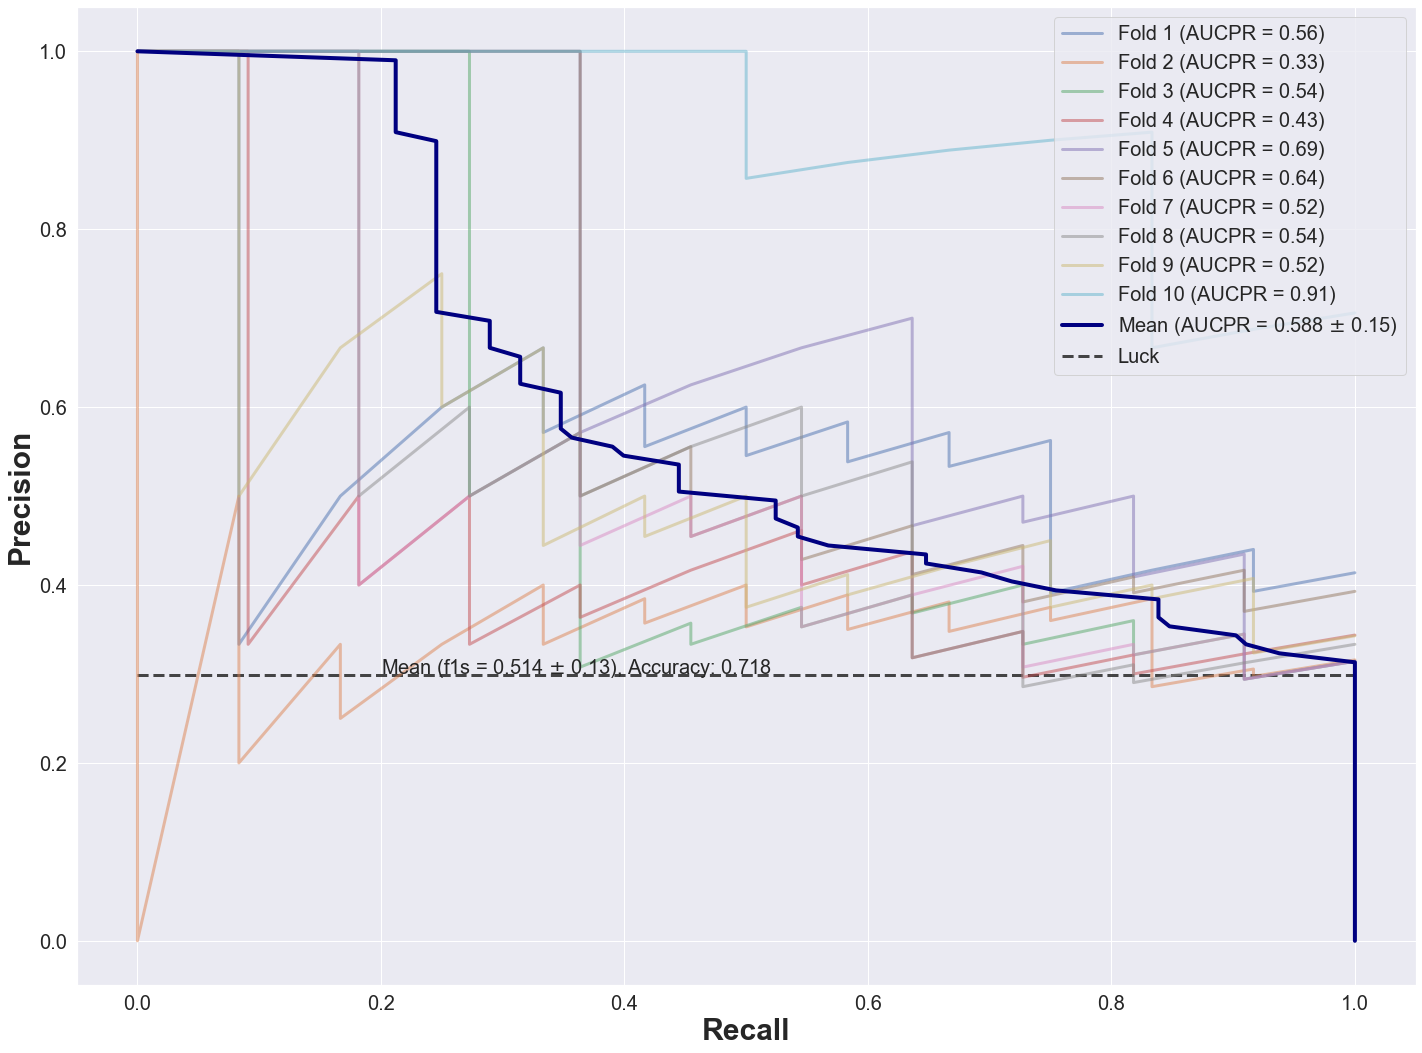

In [7]:
feature_importance = evaluation.plot_cv_precision_recall(cbc, n_folds=10, n_repeats=1, X=X, y=y, random_state=0)

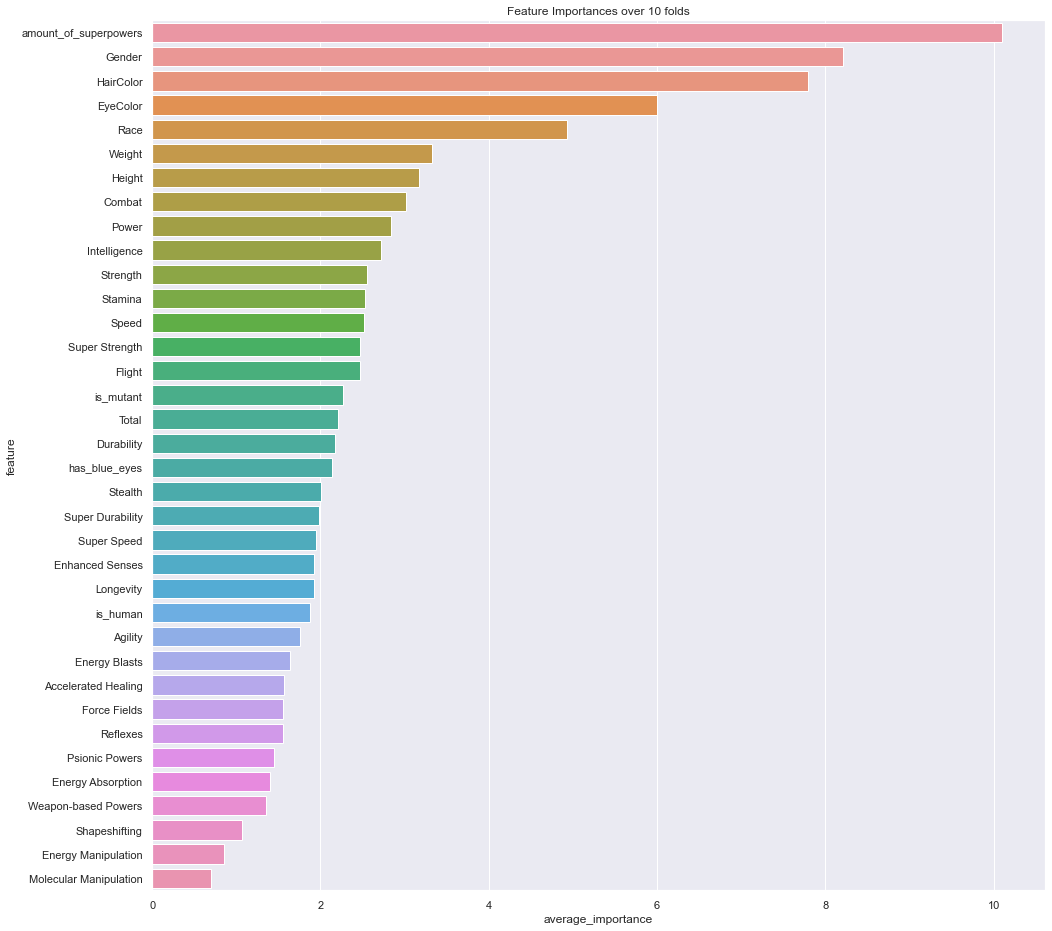

In [8]:
evaluation.plot_feature_importance(feature_importance, n_features_to_show=50)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
cbc.fit(X_train, y_train)
explainer = ClassifierExplainer(cbc, X_test, y_test)
ExplainerDashboard(explainer, simple=True).run()

Learning rate set to 0.005862
0:	learn: 0.6922923	total: 2.21ms	remaining: 2.21s
1:	learn: 0.6909185	total: 4.36ms	remaining: 2.18s
2:	learn: 0.6899974	total: 7.21ms	remaining: 2.4s
3:	learn: 0.6887307	total: 9.22ms	remaining: 2.29s
4:	learn: 0.6876136	total: 11.8ms	remaining: 2.34s
5:	learn: 0.6860938	total: 13.6ms	remaining: 2.25s
6:	learn: 0.6845523	total: 15.6ms	remaining: 2.21s
7:	learn: 0.6831367	total: 18.2ms	remaining: 2.25s
8:	learn: 0.6818703	total: 20.9ms	remaining: 2.3s
9:	learn: 0.6801012	total: 23.8ms	remaining: 2.35s
10:	learn: 0.6790493	total: 26.2ms	remaining: 2.35s
11:	learn: 0.6779982	total: 29.1ms	remaining: 2.39s
12:	learn: 0.6770499	total: 32.8ms	remaining: 2.49s
13:	learn: 0.6762585	total: 35.4ms	remaining: 2.49s
14:	learn: 0.6751063	total: 37.4ms	remaining: 2.46s
15:	learn: 0.6740682	total: 40ms	remaining: 2.46s
16:	learn: 0.6736344	total: 42.1ms	remaining: 2.44s
17:	learn: 0.6723074	total: 45.4ms	remaining: 2.48s
18:	learn: 0.6708803	total: 48.6ms	remaining: 2.

 * Running on all addresses.
 * Running on http://100.64.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [03/Jun/2021 15:46:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2021 15:46:56] "GET /assets/bootstrap.min.css?m=1622205120.162684 HTTP/1.1" 304 -
127.0.0.1 - - [03/Jun/2021 15:46:56] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2021 15:46:56] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2021 15:46:56] "GET /assets/favicon.ico?m=1622205120.1630576 HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2021 15:46:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2021 15:46:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2021 15:46:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2021 15:46:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2021 15:46:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Jun/2021 15:46:56] "POST /_dash-update-component HTTP/1.1" 200 -